# Selection of network depth and number of filters in convolutional layers

Select CNN architecture parameters to improve classification on the MNIST data.


* [The parameters studied](#The-parameters-studied)
* [Parameters Value Area](#Parameters-Value-Area)
* [Metrics](#Metrics)
* [Dataset loading](#Dataset-loading)
* [Creating a model template](#Creating-a-model-template)
* [Creating a research object](#Creating-a-research-object)
* [Results](#Results)
* [Conclusion](#Conclusion)


## The parameters studied
A number of building blocks with fixed layout i.e. network depth and a number of filters in convolutional layers.

## Parameters Value Area
A number of building blocks: [2, 3, 4, 5].

A number of filters in the first convolutional layer: [16, 32, 64].

## Metrics

Accuracy on the test set of the MNIST data.


In [1]:
import os
import sys
import glob

import dill
import numpy as np

sys.path.insert(0, os.path.join("..", ".."))
from batchflow import Pipeline, B, V, C, D
from batchflow.opensets import MNIST
from batchflow.research import Option, Research, Results
from batchflow.models.tf import TFModel
from batchflow.models.tf.layers import conv_block

from src import show_research

## Dataset loading

For training and model performance assessment we use the MNIST dataset.

In [2]:
dataset = MNIST()

## Dataset bypass:

- Define a root pipeline that will be shared between different models
- Define batch size and fix a dataset bypass order fixing the seed

In [3]:
BATCH_SIZE = 64

In [4]:
train_root = (dataset.train.p
                .run_later(BATCH_SIZE, shuffle=123, n_epochs=None))
              
test_root = (dataset.test.p
                .run_later(BATCH_SIZE, shuffle=123, n_epochs=1))

## Creating a model template

We create a small CNN architecture passing layers' parameters to `model_config`.
The parameters that will vary are defined as `C('parameter_name')`.

We vary `n_blocks` and `n_filters` - an initial number of filters in the first convolutional layer.
In each subsequent convolutional layer number of filters is doubled.

Each block has a fixed configuration layout `layout='cpna'` that corresponds to a sequence of convolution, pooling, batch normalization and activation function.

In [5]:
class ConvModel(TFModel):
    def body(cls, inputs, **kwargs):
        x = inputs
        for i in range(kwargs['n_blocks']):
            x = conv_block(x, 'cpna', filters=2 ** i * kwargs['n_filters'],
                           kernel_size=3, strides=2, pool_strides=1, name='block_' + str(i))
        return x

In [6]:
model_config = {
    'inputs/images/shape': B('image_shape'),
    'inputs/labels/classes': D('num_classes'),
    'initial_block/inputs': 'images',
    'body': dict(n_blocks=C('n_blocks'),
                 n_filters=C('n_filters')),
    'head': dict(layout='Pf', units=D('num_classes')),
    'loss': 'cross-entropy',
    'optimizer': 'Adam'}

Create training and test pipelines

In [7]:
train_template = (Pipeline()
                  .init_variable('loss') 
                  .init_model('dynamic', ConvModel, 'mnist_model', config=model_config)
                  .to_array()
                  .train_model('mnist_model', fetches='loss',
                               images=B('images'), labels=B('labels'), 
                               save_to=V('loss', mode='w')))

test_template = (Pipeline()
                 .import_model('mnist_model', C('import_from'))
                 .init_variable('loss')
                 .init_variable('predictions')
                 .init_variable('metrics')
                 .to_array()
                 .predict_model('mnist_model', fetches=['loss', 'predictions'],
                                images=B('images'), labels=B('labels'), 
                                save_to=[V('loss'), V('predictions')])
                 .gather_metrics('class', targets=B('labels'), predictions=V('predictions'),
                                 fmt='logits', axis=-1, save_to=V('metrics', mode='u')))

## Creating a research object

For each set of parameters:
- make `NUM_ITERS` iterations of train pipeline
- evaluate the model performance with the test pipeline every 10 iterations. 
- repeat the whole procedure `NUM_REPEATS` times.

In [8]:
op1 = Option('n_blocks', [2, 3, 4, 5])
op2 = Option('n_filters', [16, 32, 64])
grid = op1 * op2

research = (Research()
            .add_pipeline(train_root+train_template, variables='loss', name='train')
            .add_pipeline(test_root+test_template, variables='loss', name='test', execute=10,
                          run=True, import_from='train')
            .get_metrics(pipeline='test', metrics_var='metrics', metrics_name='accuracy',
                         returns='accuracy', execute=10)
            .add_grid(grid))

In [9]:
NUM_REPEATS = 3
NUM_ITERS = 100
research_name = 'blocks_filters_research'

In [10]:
research.run(n_reps=NUM_REPEATS, n_iters=NUM_ITERS, branches=1, name=research_name, bar=True, workers=1, gpu=[4])

Research blocks_filters_research is starting...


  0%|          | 0/3600 [00:00<?, ?it/s]

Distributor has 36 jobs with 100 iterations. Totally: 3600


100%|██████████| 3600/3600 [20:36<00:00,  2.91it/s]


## Results

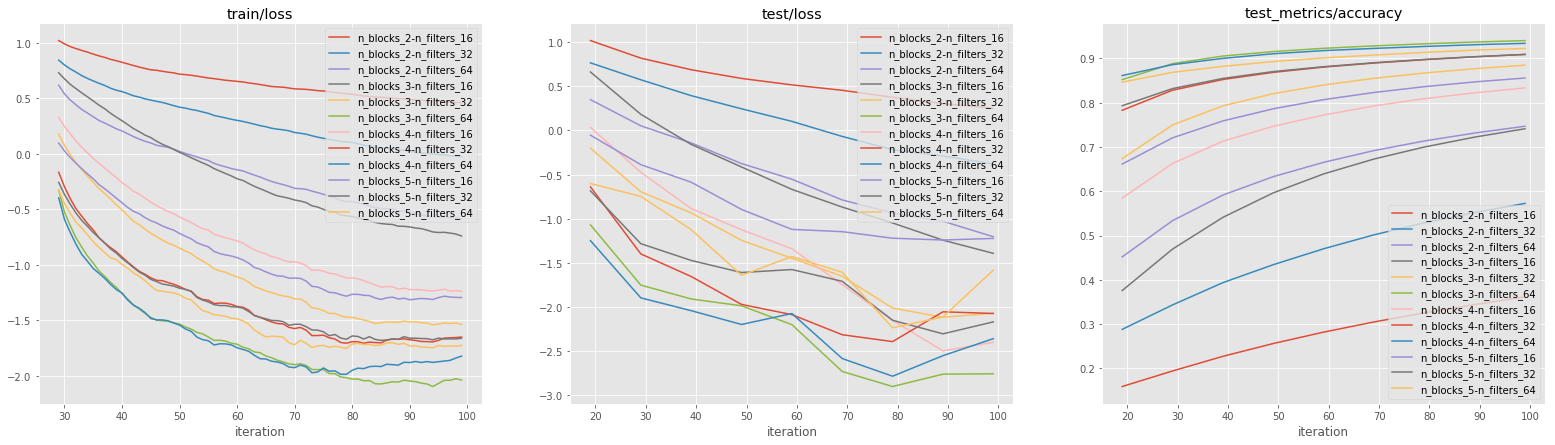

In [11]:
data = Results(path=research_name).load(use_alias=True)
show_research(data, average_repetitions=True, log_scale=[True, True, False],
              layout=['train/loss', 'test/loss', 'test_metrics/accuracy'],
              rolling_window=[30, 2, 2])

## Conclusion

As it can be seen on the test accuracy plot, the best model is the one with parameters `n_blocks=3, n_filters=64`.

Despite the fact that the chosen configuration of the model was on average better than others, it is useful, along with a point estimate, to obtain the distribution of the metric over N independent runs of the training procedure.